<a href="https://colab.research.google.com/github/MxFxM/ColabCodes/blob/master/PancakeComparator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Resized image 1


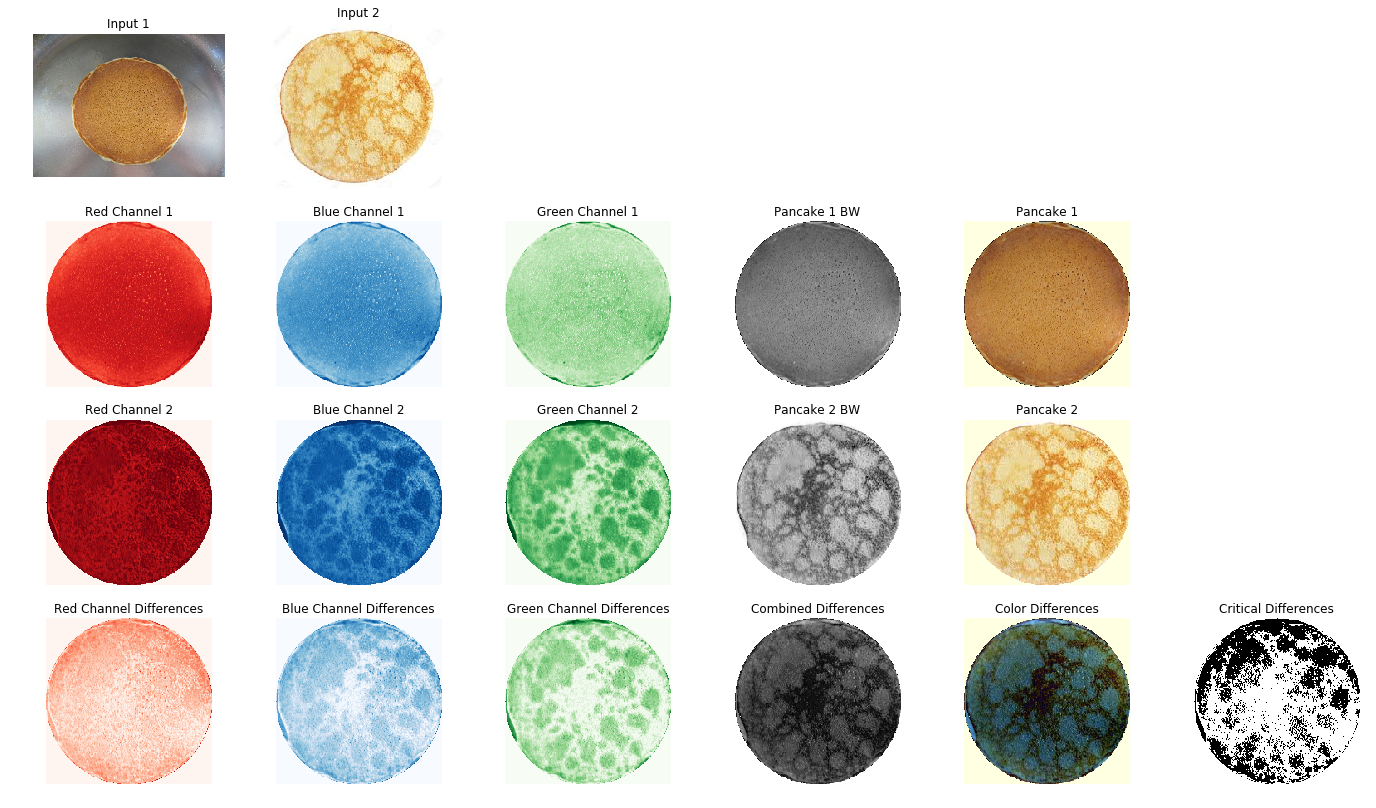

In [0]:
#@title PanCakes
"""
This code takes two image names as input
and compares the pancakes in the images.

Hopefuly there actually is a pancake
and it is completly in the picture (not like pc_03),
otherwise I guarantee for nothing.
There also should be only one circle (pancake) in the image.

Image format has to be .jpg

Procedure:
- open images
- get pancakes:
    - blur image
    - detect edges
    - detect circles
- focus on pancakes:
    - cut circled image as rectangle
    - black out non-circular parts
- compare:
    - resize bigger image (so no new data is included)
    - find color differences per picture
    - find color differences between pictures
- plot results
"""

from matplotlib import pyplot as plt
import numpy as np
import cv2
from google.colab import drive
drive.mount('/content/gdrive')

PATH = "/content/gdrive/My Drive/Colab Notebooks/pancakes/"
FILENAME1 = "pc_01"
FILENAME2 = "pc_05"

# region open images
img1 = cv2.imread(f"{PATH}{FILENAME1}.jpg")
b, g, r = cv2.split(img1)
img1 = cv2.merge([r, g, b])
img2 = cv2.imread(f"{PATH}{FILENAME2}.jpg")
b, g, r = cv2.split(img2)
img2 = cv2.merge([r, g, b])
# endregion

# region blur image to get smooth edges
KSIZE = 9
img1_blur = cv2.medianBlur(img1, KSIZE)
img2_blur = cv2.medianBlur(img2, KSIZE)
# endregion

# region detect edges
THRESHOLD1 = 100
THRESHOLD2 = 200
APERTURESIZE = 3
L2GRAD = True
img1_edges = cv2.Canny(img1_blur, THRESHOLD1, THRESHOLD2,
                       apertureSize=APERTURESIZE, L2gradient=L2GRAD)
img2_edges = cv2.Canny(img2_blur, THRESHOLD1, THRESHOLD2,
                       apertureSize=APERTURESIZE, L2gradient=L2GRAD)
# endregion

# region detect circles
METHOD = cv2.HOUGH_GRADIENT
PD = 1
MINIMUMDISTANCE = 500
SENSITIVITY = 50
ROUNDNESS = 10
MINRAD = 0
MAXRAD = 0
anyerror = False
try:
    circles1 = cv2.HoughCircles(img1_edges, METHOD, PD, MINIMUMDISTANCE,
                                param1=SENSITIVITY, param2=ROUNDNESS, minRadius=MINRAD, maxRadius=MAXRAD)
    circles1 = np.uint16(np.around(circles1))
except Exception as e:
    print(e)
    print("propably no pancake in picture 1")
    anyerror = True
try:
    circles2 = cv2.HoughCircles(img2_edges, METHOD, PD, MINIMUMDISTANCE,
                                param1=SENSITIVITY, param2=ROUNDNESS, minRadius=MINRAD, maxRadius=MAXRAD)
    circles2 = np.uint16(np.around(circles2))
except Exception as e:
    print(e)
    print("propably no pancake in picture 2")
    anyerror = True
if anyerror:
    quit()
pc_pos1 = []
pc_pos2 = []
for i in circles1[0, :]:
    # (x, y) is center
    # image to draw on, (x, y), radius, (R,G,B), thickness
    # cv2.circle(img1, (i[0], i[1]), i[2], (0, 255, 0), 1)
    pc_pos1.append(i[0])
    pc_pos1.append(i[1])
    pc_pos1.append(i[2])
for i in circles2[0, :]:
    # cv2.circle(img2, (i[0], i[1]), i[2], (0, 255, 0), 1)
    pc_pos2.append(i[0])
    pc_pos2.append(i[1])
    pc_pos2.append(i[2])
# endregion

# region cut circled image as rectangle
OFFSET = 0  # makes circle bigger than detected !!compares pan!!
pc_pos1[2] = pc_pos1[2] + OFFSET
pc_pos2[2] = pc_pos2[2] + OFFSET
anyerror = False
if pc_pos1[1]-pc_pos1[2] < 0 or pc_pos1[1]+pc_pos1[2] > img1.shape[0]:
    print("pancake 1 not completly in picture in y axis")
    anyerror = True
if pc_pos2[1]-pc_pos2[2] < 0 or pc_pos2[1]+pc_pos2[2] > img2.shape[0]:
    print("pancake 2 not completly in picture in y axis")
    anyerror = True
if pc_pos1[0]-pc_pos1[2] < 0 or pc_pos1[0]+pc_pos1[2] > img1.shape[1]:
    print("pancake 1 not completly in picture in x axis")
    anyerror = True
if pc_pos2[0]-pc_pos2[2] < 0 or pc_pos2[0]+pc_pos2[2] > img2.shape[1]:
    print("pancake 2 not completly in picture in x axis")
    anyerror = True
if anyerror:
    quit()
# [y:y+h, x:x+h]
img1_rect = img1[pc_pos1[1]-pc_pos1[2]:pc_pos1[1]+pc_pos1[2],
                 pc_pos1[0]-pc_pos1[2]:pc_pos1[0]+pc_pos1[2]].copy()
img2_rect = img2[pc_pos2[1]-pc_pos2[2]:pc_pos2[1]+pc_pos2[2],
                 pc_pos2[0]-pc_pos2[2]:pc_pos2[0]+pc_pos2[2]].copy()
# endregion

# region black out non-circular parts
# point in and on circle: (x - center_x)^2 + (y - center_y)^2 <= radius^2
h1 = img1_rect.shape[0]
w1 = img1_rect.shape[1]
for ypos in range(h1):
    for xpos in range(w1):
        if (xpos - len(img1_rect[ypos])/2)**2 + (ypos - len(img1_rect)/2)**2 > pc_pos1[2]**2:
            img1_rect[ypos][xpos] = [0, 0, 0]
h2 = img2_rect.shape[0]
w2 = img2_rect.shape[1]
for ypos in range(h2):
    for xpos in range(w2):
        if (xpos - len(img2_rect[ypos])/2)**2 + (ypos - len(img2_rect)/2)**2 > pc_pos2[2]**2:
            img2_rect[ypos][xpos] = [0, 0, 0]
# endregion

# region resize bigger image
# (new_x, new_y)
if h1 < h2 and w1 < w2:  # img1 is smaller in all dimensions
    img2_rect = cv2.resize(img2_rect, (w1, h1))
    print("Resized image 2")
elif h1 > h2 and w1 > w2:  # img2 is bigger in all dimensions
    img1_rect = cv2.resize(img1_rect, (w2, h2))
    print("Resized image 1")
elif h1 < h2 and w1 > w2:  # img1 is shorter but wider
    img1_rect = cv2.resize(img1_rect, (w2, h1))  # this can not happen (round)
    img2_rect = cv2.resize(img2_rect, (w2, h1))  # this can not happen (round)
    print("Resized image 1 and 2")
elif h1 > h2 and w1 < w2:  # img1 is higher but thinner
    img1_rect = cv2.resize(img1_rect, (w1, h2))  # this can not happen (round)
    img2_rect = cv2.resize(img2_rect, (w1, h2))  # this can not happen (round)
    print("Resized image 1 and 2")
elif h1 < h2:  # img1 is shorter
    img2_rect = cv2.resize(img2_rect, (w1, h1))  # this can not happen (round)
    print("Resized image 2")
elif h1 > h2:  # img1 is higher
    img1_rect = cv2.resize(img1_rect, (w2, h2))  # this can not happen (round)
    print("Resized image 1")
elif w1 < w2:  # img1 is thinner
    img2_rect = cv2.resize(img2_rect, (w1, h1))  # this can not happen (round)
    print("Resized image 2")
elif w1 > w2:  # img1 is wider
    img1_rect = cv2.resize(img1_rect, (w2, h2))  # this can not happen (round)
    print("Resized image 1")
else:  # same exact size
    print("Resized no image")
# endregion

# region find color differences per picture
CRITICALTHRESHOLD = 100
red1_diff = []
green1_diff = []
blue1_diff = []
all1_diff = []
img1_diff = []
w = img1_rect.shape[1]
h = img1_rect.shape[0]
for ypos in range(h):
    r_diff = []
    g_diff = []
    b_diff = []
    a1_diff = []
    a2_diff = []
    c = []
    for xpos in range(w):
        r_diff.append(int(img1_rect[ypos][xpos][0]))
        g_diff.append(int(img1_rect[ypos][xpos][1]))
        b_diff.append(int(img1_rect[ypos][xpos][2]))
        if int((r_diff[-1] + g_diff[-1] + b_diff[-1])/3) != 0:
            a1_diff.append(int((r_diff[-1] + g_diff[-1] + b_diff[-1])/3))
            a2_diff.append([r_diff[-1], g_diff[-1], b_diff[-1]])
        else:
            a1_diff.append(255)
            a2_diff.append([255, 255, 225])
    red1_diff.append(r_diff)
    green1_diff.append(g_diff)
    blue1_diff.append(b_diff)
    all1_diff.append(a1_diff)
    img1_diff.append(a2_diff)
red1_diff = np.array(red1_diff)
green1_diff = np.array(green1_diff)
blue1_diff = np.array(blue1_diff)
all1_diff = np.array(all1_diff)
img1_diff = np.array(img1_diff)

red2_diff = []
green2_diff = []
blue2_diff = []
all2_diff = []
img2_diff = []
w = img2_rect.shape[1]
h = img2_rect.shape[0]
for ypos in range(h):
    r_diff = []
    g_diff = []
    b_diff = []
    a1_diff = []
    a2_diff = []
    c = []
    for xpos in range(w):
        r_diff.append(int(img2_rect[ypos][xpos][0]))
        g_diff.append(int(img2_rect[ypos][xpos][1]))
        b_diff.append(int(img2_rect[ypos][xpos][2]))
        if int((r_diff[-1] + g_diff[-1] + b_diff[-1])/3) != 0:
            a1_diff.append(int((r_diff[-1] + g_diff[-1] + b_diff[-1])/3))
            a2_diff.append([r_diff[-1], g_diff[-1], b_diff[-1]])
        else:
            a1_diff.append(255)
            a2_diff.append([255, 255, 225])
            c.append(255)
    red2_diff.append(r_diff)
    green2_diff.append(g_diff)
    blue2_diff.append(b_diff)
    all2_diff.append(a1_diff)
    img2_diff.append(a2_diff)
red2_diff = np.array(red2_diff)
green2_diff = np.array(green2_diff)
blue2_diff = np.array(blue2_diff)
all2_diff = np.array(all2_diff)
img2_diff = np.array(img2_diff)
# endregion

# region find color differences between pictures
CRITICALTHRESHOLD = 70
red_diff = []
green_diff = []
blue_diff = []
all_diff = []
img_diff = []
crit = []
w = img1_rect.shape[1]
h = img1_rect.shape[0]
for ypos in range(h):
    r_diff = []
    g_diff = []
    b_diff = []
    a1_diff = []
    a2_diff = []
    c = []
    for xpos in range(w):
        r_diff.append(abs(int(img1_rect[ypos][xpos][0]) -
                          int(img2_rect[ypos][xpos][0])))
        g_diff.append(abs(int(img1_rect[ypos][xpos][1]) -
                          int(img2_rect[ypos][xpos][1])))
        b_diff.append(abs(int(img1_rect[ypos][xpos][2]) -
                          int(img2_rect[ypos][xpos][2])))
        if int((r_diff[-1] + g_diff[-1] + b_diff[-1])/3) != 0:
            a1_diff.append(int((r_diff[-1] + g_diff[-1] + b_diff[-1])/3))
            if a1_diff[-1] > CRITICALTHRESHOLD:
                c.append(0)
            else:
                c.append(255)
            a2_diff.append([r_diff[-1], g_diff[-1], b_diff[-1]])
        else:
            a1_diff.append(255)
            a2_diff.append([255, 255, 225])
            c.append(255)
    red_diff.append(r_diff)
    green_diff.append(g_diff)
    blue_diff.append(b_diff)
    all_diff.append(a1_diff)
    img_diff.append(a2_diff)
    crit.append(c)
red_diff = np.array(red_diff)
green_diff = np.array(green_diff)
blue_diff = np.array(blue_diff)
all_diff = np.array(all_diff)
img_diff = np.array(img_diff)
crit = np.array(crit)
# endregion

# region plot results
fig = plt.figure()
fig.set_size_inches(24, 14)

plt.subplot(4, 6, 1), plt.imshow(img1)
plt.axis("off")
plt.title("Input 1")
# plt.subplot(4, 6, 4), plt.imshow(img1_rect)  # , cmap='gray')
# plt.title("Pancake 1")
# plt.axis("off")
plt.subplot(4, 6, 2), plt.imshow(img2)
plt.title("Input 2")
plt.axis("off")
# plt.subplot(4, 6, 5), plt.imshow(img2_rect)  # , cmap='gray')
# plt.title("Pancake 2")
# plt.axis("off")

plt.subplot(4, 6, 7), plt.imshow(red1_diff, cmap='Reds')
plt.title("Red Channel 1")
plt.axis("off")
plt.subplot(4, 6, 8), plt.imshow(green1_diff, cmap='Blues')
plt.title("Blue Channel 1")
plt.axis("off")
plt.subplot(4, 6, 9), plt.imshow(blue1_diff, cmap='Greens')
plt.title("Green Channel 1")
plt.axis("off")
plt.subplot(4, 6, 10), plt.imshow(all1_diff, cmap='gray')
plt.title("Pancake 1 BW")
plt.axis("off")
plt.subplot(4, 6, 11), plt.imshow(img1_diff)
plt.title("Pancake 1")
plt.axis("off")

plt.subplot(4, 6, 13), plt.imshow(red2_diff, cmap='Reds')
plt.title("Red Channel 2")
plt.axis("off")
plt.subplot(4, 6, 14), plt.imshow(green2_diff, cmap='Blues')
plt.title("Blue Channel 2")
plt.axis("off")
plt.subplot(4, 6, 15), plt.imshow(blue2_diff, cmap='Greens')
plt.title("Green Channel 2")
plt.axis("off")
plt.subplot(4, 6, 16), plt.imshow(all2_diff, cmap='gray')
plt.title("Pancake 2 BW")
plt.axis("off")
plt.subplot(4, 6, 17), plt.imshow(img2_diff)
plt.title("Pancake 2")
plt.axis("off")

plt.subplot(4, 6, 19), plt.imshow(red_diff, cmap='Reds')
plt.title("Red Channel Differences")
plt.axis("off")
plt.subplot(4, 6, 20), plt.imshow(green_diff, cmap='Blues')
plt.title("Blue Channel Differences")
plt.axis("off")
plt.subplot(4, 6, 21), plt.imshow(blue_diff, cmap='Greens')
plt.title("Green Channel Differences")
plt.axis("off")
plt.subplot(4, 6, 22), plt.imshow(all_diff, cmap='gray')
plt.title("Combined Differences")
plt.axis("off")
plt.subplot(4, 6, 23), plt.imshow(img_diff)
plt.title("Color Differences")
plt.axis("off")
plt.subplot(4, 6, 24), plt.imshow(crit, cmap='gray')
plt.title("Critical Differences")
plt.axis("off")

# optional full screen results
# mng = plt.get_current_fig_manager()
# mng.window.state('zoomed')
# end

plt.show()
# endregion


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


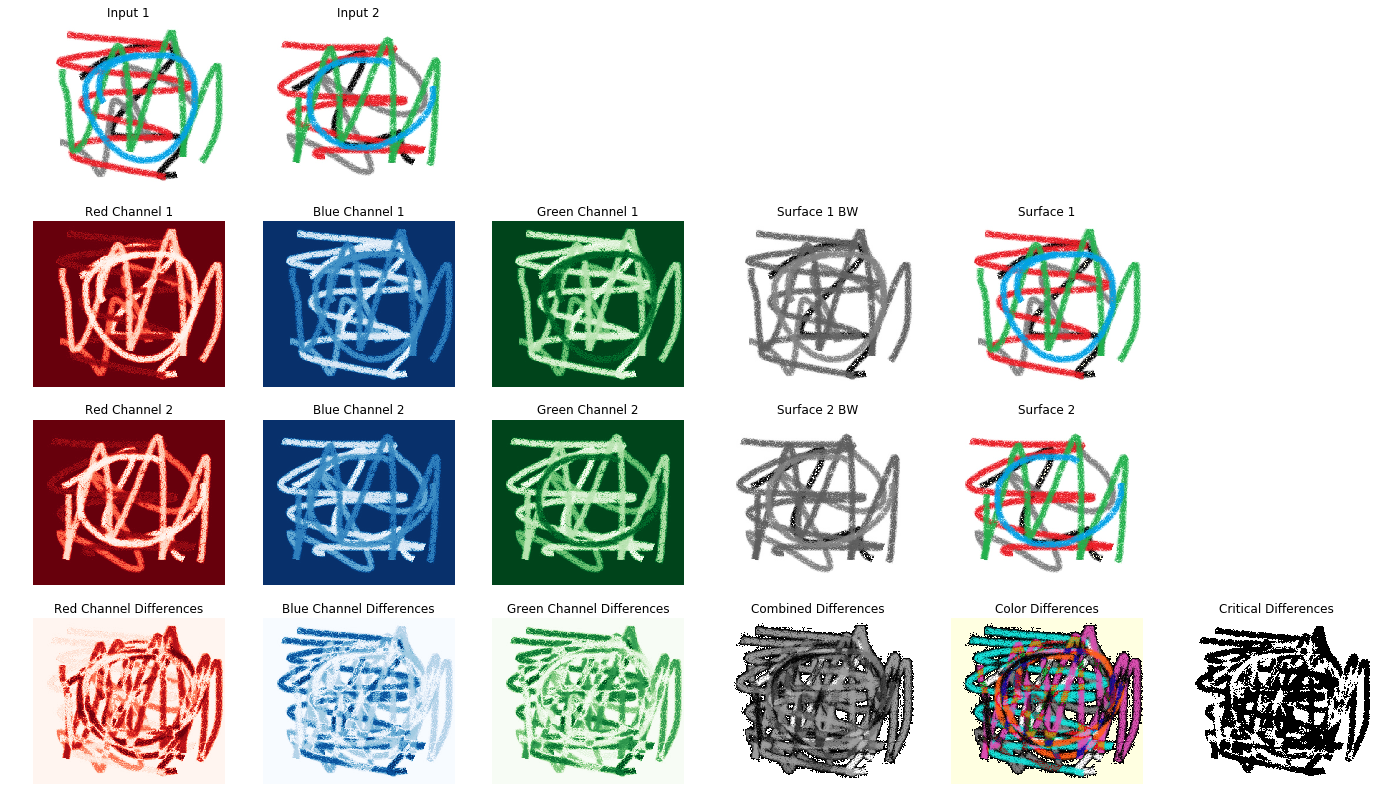

In [0]:
#@title Bilder ohne Kreis

from matplotlib import pyplot as plt
import numpy as np
import cv2
from google.colab import drive
drive.mount('/content/gdrive')

PATH = "/content/gdrive/My Drive/Colab Notebooks/pancakes/"
FILENAME1 = "Unbenannt1"
FILENAME2 = "Unbenannt2"

# region open images
img1 = cv2.imread(f"{PATH}{FILENAME1}.jpg")
b, g, r = cv2.split(img1)
img1 = cv2.merge([r, g, b])
img2 = cv2.imread(f"{PATH}{FILENAME2}.jpg")
b, g, r = cv2.split(img2)
img2 = cv2.merge([r, g, b])
# endregion

# region image as rectangle
img1_rect = img1
img2_rect = img2
# endregion

# region find color differences per picture
CRITICALTHRESHOLD = 100
red1_diff = []
green1_diff = []
blue1_diff = []
all1_diff = []
img1_diff = []
w = img1_rect.shape[1]
h = img1_rect.shape[0]
for ypos in range(h):
    r_diff = []
    g_diff = []
    b_diff = []
    a1_diff = []
    a2_diff = []
    c = []
    for xpos in range(w):
        r_diff.append(int(img1_rect[ypos][xpos][0]))
        g_diff.append(int(img1_rect[ypos][xpos][1]))
        b_diff.append(int(img1_rect[ypos][xpos][2]))
        if int((r_diff[-1] + g_diff[-1] + b_diff[-1])/3) != 0:
            a1_diff.append(int((r_diff[-1] + g_diff[-1] + b_diff[-1])/3))
            a2_diff.append([r_diff[-1], g_diff[-1], b_diff[-1]])
        else:
            a1_diff.append(255)
            a2_diff.append([255, 255, 225])
    red1_diff.append(r_diff)
    green1_diff.append(g_diff)
    blue1_diff.append(b_diff)
    all1_diff.append(a1_diff)
    img1_diff.append(a2_diff)
red1_diff = np.array(red1_diff)
green1_diff = np.array(green1_diff)
blue1_diff = np.array(blue1_diff)
all1_diff = np.array(all1_diff)
img1_diff = np.array(img1_diff)

red2_diff = []
green2_diff = []
blue2_diff = []
all2_diff = []
img2_diff = []
w = img2_rect.shape[1]
h = img2_rect.shape[0]
for ypos in range(h):
    r_diff = []
    g_diff = []
    b_diff = []
    a1_diff = []
    a2_diff = []
    c = []
    for xpos in range(w):
        r_diff.append(int(img2_rect[ypos][xpos][0]))
        g_diff.append(int(img2_rect[ypos][xpos][1]))
        b_diff.append(int(img2_rect[ypos][xpos][2]))
        if int((r_diff[-1] + g_diff[-1] + b_diff[-1])/3) != 0:
            a1_diff.append(int((r_diff[-1] + g_diff[-1] + b_diff[-1])/3))
            a2_diff.append([r_diff[-1], g_diff[-1], b_diff[-1]])
        else:
            a1_diff.append(255)
            a2_diff.append([255, 255, 225])
            c.append(255)
    red2_diff.append(r_diff)
    green2_diff.append(g_diff)
    blue2_diff.append(b_diff)
    all2_diff.append(a1_diff)
    img2_diff.append(a2_diff)
red2_diff = np.array(red2_diff)
green2_diff = np.array(green2_diff)
blue2_diff = np.array(blue2_diff)
all2_diff = np.array(all2_diff)
img2_diff = np.array(img2_diff)
# endregion

# region find color differences between pictures
CRITICALTHRESHOLD = 70
red_diff = []
green_diff = []
blue_diff = []
all_diff = []
img_diff = []
crit = []
w = img1_rect.shape[1]
h = img1_rect.shape[0]
for ypos in range(h):
    r_diff = []
    g_diff = []
    b_diff = []
    a1_diff = []
    a2_diff = []
    c = []
    for xpos in range(w):
        r_diff.append(abs(int(img1_rect[ypos][xpos][0]) -
                          int(img2_rect[ypos][xpos][0])))
        g_diff.append(abs(int(img1_rect[ypos][xpos][1]) -
                          int(img2_rect[ypos][xpos][1])))
        b_diff.append(abs(int(img1_rect[ypos][xpos][2]) -
                          int(img2_rect[ypos][xpos][2])))
        if int((r_diff[-1] + g_diff[-1] + b_diff[-1])/3) != 0:
            a1_diff.append(int((r_diff[-1] + g_diff[-1] + b_diff[-1])/3))
            if a1_diff[-1] > CRITICALTHRESHOLD:
                c.append(0)
            else:
                c.append(255)
            a2_diff.append([r_diff[-1], g_diff[-1], b_diff[-1]])
        else:
            a1_diff.append(255)
            a2_diff.append([255, 255, 225])
            c.append(255)
    red_diff.append(r_diff)
    green_diff.append(g_diff)
    blue_diff.append(b_diff)
    all_diff.append(a1_diff)
    img_diff.append(a2_diff)
    crit.append(c)
red_diff = np.array(red_diff)
green_diff = np.array(green_diff)
blue_diff = np.array(blue_diff)
all_diff = np.array(all_diff)
img_diff = np.array(img_diff)
crit = np.array(crit)
# endregion

# region plot results
fig = plt.figure()
fig.set_size_inches(24, 14)

plt.subplot(4, 6, 1), plt.imshow(img1)
plt.axis("off")
plt.title("Input 1")
# plt.subplot(4, 6, 4), plt.imshow(img1_rect)  # , cmap='gray')
# plt.title("Pancake 1")
# plt.axis("off")
plt.subplot(4, 6, 2), plt.imshow(img2)
plt.title("Input 2")
plt.axis("off")
# plt.subplot(4, 6, 5), plt.imshow(img2_rect)  # , cmap='gray')
# plt.title("Pancake 2")
# plt.axis("off")

plt.subplot(4, 6, 7), plt.imshow(red1_diff, cmap='Reds')
plt.title("Red Channel 1")
plt.axis("off")
plt.subplot(4, 6, 8), plt.imshow(green1_diff, cmap='Blues')
plt.title("Blue Channel 1")
plt.axis("off")
plt.subplot(4, 6, 9), plt.imshow(blue1_diff, cmap='Greens')
plt.title("Green Channel 1")
plt.axis("off")
plt.subplot(4, 6, 10), plt.imshow(all1_diff, cmap='gray')
plt.title("Surface 1 BW")
plt.axis("off")
plt.subplot(4, 6, 11), plt.imshow(img1_diff)
plt.title("Surface 1")
plt.axis("off")

plt.subplot(4, 6, 13), plt.imshow(red2_diff, cmap='Reds')
plt.title("Red Channel 2")
plt.axis("off")
plt.subplot(4, 6, 14), plt.imshow(green2_diff, cmap='Blues')
plt.title("Blue Channel 2")
plt.axis("off")
plt.subplot(4, 6, 15), plt.imshow(blue2_diff, cmap='Greens')
plt.title("Green Channel 2")
plt.axis("off")
plt.subplot(4, 6, 16), plt.imshow(all2_diff, cmap='gray')
plt.title("Surface 2 BW")
plt.axis("off")
plt.subplot(4, 6, 17), plt.imshow(img2_diff)
plt.title("Surface 2")
plt.axis("off")

plt.subplot(4, 6, 19), plt.imshow(red_diff, cmap='Reds')
plt.title("Red Channel Differences")
plt.axis("off")
plt.subplot(4, 6, 20), plt.imshow(green_diff, cmap='Blues')
plt.title("Blue Channel Differences")
plt.axis("off")
plt.subplot(4, 6, 21), plt.imshow(blue_diff, cmap='Greens')
plt.title("Green Channel Differences")
plt.axis("off")
plt.subplot(4, 6, 22), plt.imshow(all_diff, cmap='gray')
plt.title("Combined Differences")
plt.axis("off")
plt.subplot(4, 6, 23), plt.imshow(img_diff)
plt.title("Color Differences")
plt.axis("off")
plt.subplot(4, 6, 24), plt.imshow(crit, cmap='gray')
plt.title("Critical Differences")
plt.axis("off")

# optional full screen results
# mng = plt.get_current_fig_manager()
# mng.window.state('zoomed')
# end

plt.show()
# endregion